In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import mannwhitneyu
from matplotlib.colors import LinearSegmentedColormap

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Directory containing the .tsv FACETS CN segments files for each dataset, including filtered ones.
# Default repo location given.
# External datasets not included with our repo- you will have to generate these yourself

input_dir = "../../data/"
CN_dir = input_dir + "copy_number/"
dataset_names = ["HTAN_WGS", "HTAN_WES", "PUTH", "SCORT"]

resource_dir = "../../data/resource/"

FGA_dir = CN_dir+"fraction_genome_altered/"

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
removed_regions_loc = resource_dir+"hg38.UCSC.centromere.telomere.encode.bed"

removed_regions = pd.read_csv(removed_regions_loc, sep="\t", names=["chrom", "start_pos", "end_pos", "length", "source", "reason"])

telomere_table = removed_regions[removed_regions["reason"]=="telomere"]

chroms = []
starts = []
ends = []
for chrom in list(set(telomere_table["chrom"])):
    only_chrom = telomere_table[telomere_table["chrom"]==chrom]
    chroms.append(chrom)
    starts.append(only_chrom.iloc[0]["end_pos"])
    ends.append(only_chrom.iloc[1]["start_pos"])
telomere_table = pd.DataFrame({"start":starts, "end":ends}, index=chroms)
telomere_table["length"] = telomere_table["end"] - telomere_table["start"]

In [4]:
centromeres = removed_regions[~np.isin(removed_regions["reason"], ['High Signal Region','Low Mappability','telomere'])]
centromeres_summary = pd.DataFrame(centromeres.groupby("chrom").min()["start_pos"])
centromeres_summary = centromeres_summary.join(centromeres.groupby("chrom").max()["end_pos"])

chrs_to_plot = ["chr"+str(x) for x in range(1,23)]
cent_start_plot = []
cent_end_plot = []
curr_pos = 0
chr_start = []
chr_end = []
for chrom in chrs_to_plot:
    chr_start.append(curr_pos)
    cent_start_plot.append(centromeres_summary.loc[chrom]["start_pos"] - telomere_table.loc[chrom]["start"] + curr_pos)
    cent_end_plot.append(centromeres_summary.loc[chrom]["end_pos"] - telomere_table.loc[chrom]["start"] + curr_pos)
    curr_pos += telomere_table.loc[chrom]["length"]
    chr_end.append(curr_pos)
centromeres_plot = pd.DataFrame({"start_plot": cent_start_plot, "end_plot":cent_end_plot, "chr_start":chr_start, "chr_end":chr_end}, index=chrs_to_plot)
centromeres_plot["chr_mid"] = (centromeres_plot["chr_start"] + centromeres_plot["chr_end"])/2

In [5]:
HTAN_metadata = pd.read_csv(input_dir+"Table_S2.csv", index_col=0)
PUTH_metadata = pd.read_csv(input_dir+"PUTH_exonic_mutation_burden.tsv", sep="\t", index_col=0)
SCORT_metadata = pd.read_csv(input_dir+"SCORT_exonic_mutation_burden.tsv", sep="\t", index_col=0)

sample_to_stage = dict(zip(HTAN_metadata.index, HTAN_metadata["Stage"]))
sample_to_stage.update(dict(zip(PUTH_metadata.index, PUTH_metadata["Stage"])))
sample_to_stage.update(dict(zip(SCORT_metadata.index, SCORT_metadata["Stage"])))

sample_to_lesion = dict(zip(HTAN_metadata.index, HTAN_metadata.index))
sample_to_lesion.update(dict(zip(PUTH_metadata.index, ["_".join(x.split("_")[:3]) for x in PUTH_metadata.index])))
sample_to_lesion.update(dict(zip(SCORT_metadata.index, ["_".join(x.split("_")[:-1]) for x in SCORT_metadata.index])))

merged_filtered_datasets = {}
fga = {}
for dataset in dataset_names:
    doubling_to_add = pd.read_csv(CN_dir+"genome_doubling/"+dataset+"_doubled.tsv", sep="\t", index_col=0)
    sample_to_WGD = dict(zip(doubling_to_add.index, doubling_to_add["genome_doubled"]))
    data_to_add = pd.read_csv(CN_dir+dataset+"_CN_filtered_merged.tsv", sep="\t")
    data_to_add["WGD"] = [sample_to_WGD[x] for x in data_to_add["sample_id"]]
    data_to_add["stage"] = [sample_to_stage[x] for x in data_to_add["sample_id"]]
    data_to_add["lesion"] = [sample_to_lesion[x] for x in data_to_add["sample_id"]]
    merged_filtered_datasets[dataset] = data_to_add[~data_to_add["WGD"]]
    FGA_to_add = pd.read_csv(FGA_dir+dataset+"_fga.tsv", sep="\t", names=["Tumor_Sample_Barcode", "FGA"])
    FGA_to_add["stage"] = [sample_to_stage[x] for x in FGA_to_add["Tumor_Sample_Barcode"]]
    FGA_to_add["lesion"] = [sample_to_lesion[x] for x in FGA_to_add["Tumor_Sample_Barcode"]]
    FGA_to_add["WGD"] = [sample_to_WGD[x] for x in FGA_to_add["Tumor_Sample_Barcode"]]
    fga[dataset] = FGA_to_add#[~FGA_to_add["WGD"]]
    
if "HTAN_WES" in dataset_names and "HTAN_WGS" in dataset_names:
    HTAN_CNs = merged_filtered_datasets["HTAN_WGS"]
    to_add = merged_filtered_datasets["HTAN_WES"]
    HTAN_CNs = pd.concat([HTAN_CNs, to_add[np.isin(to_add["sample_id"], HTAN_metadata[HTAN_metadata["Has_WGS"]=="No"].index.to_list())]])
    HTAN_FGA = fga["HTAN_WGS"]
    to_add = fga["HTAN_WES"]
    HTAN_FGA = pd.concat([HTAN_FGA, to_add[np.isin(to_add["Tumor_Sample_Barcode"], HTAN_metadata[HTAN_metadata["Has_WGS"]=="No"].index.to_list())]])
elif "HTAN_WES" in dataset_names:
    HTAN_CNs = merged_filtered_datasets["HTAN_WES"]
    HTAN_FGA = fga["HTAN_WES"]
elif "HTAN_WGS" in dataset_names:
    HTAN_CNs = merged_filtered_datasets["HTAN_WGS"]
    HTAN_FGA = fga["HTAN_WGS"]
else:
    raise AssertionError("No HTAN dataset provided")

In [6]:
def darken_rgb(rgb, darken_factor):
    return (max(0,rgb[0]-darken_factor), max(0,rgb[1]-darken_factor), max(0,rgb[2]-darken_factor))

def plot_population_CNs(CN_df):
    chrs_to_plot = ["chr"+str(x) for x in range(1,23)]
    n_samples = len(set(CN_df["sample_id"]))
    print(n_samples, "samples total")
    print(len(set(CN_df["lesion"])), "lesions")
    
    chroms = []
    positions = []
    gains = []
    losses = []
    for i in range(len(CN_df)):
        row = CN_df.iloc[i]
        if row["tcn_em"] != 2 and row["chrom"] in chrs_to_plot:
            chroms.append(row["chrom"])
            chroms.append(row["chrom"])
            positions.append(row["loc_start"])
            positions.append(row["loc_end"])
            
            if row["tcn_em"] > 2:
                gains.extend([1, -1])
                losses.extend([0,0])
            else:
                #print(row)
                losses.extend([-1, 1])
                gains.extend([0,0])
    plotting_df = pd.DataFrame({"chrom":chroms, "position":positions, "gain":gains, "loss":losses})
    
    to_concat = []
    current_x_coord = 0
    for chrom in chrs_to_plot:
        only_chrom = plotting_df[plotting_df["chrom"] == chrom].sort_values("position")
        only_chrom["gains_cumulative"] = np.cumsum(only_chrom["gain"])/n_samples
        only_chrom["losses_cumulative"] = np.cumsum(only_chrom["loss"])/n_samples
        only_chrom.drop_duplicates(subset="position", keep="last", inplace=True)
        only_chrom["plot_position"] = current_x_coord + only_chrom["position"]
        current_x_coord += telomere_table.loc[chrom]["length"]
        to_concat.append(only_chrom)
    to_plot = pd.concat(to_concat, ignore_index=True)

    fig, ax = plt.subplots(1,1,figsize=(12,2))
    plt.fill_between(to_plot["plot_position"], to_plot["gains_cumulative"], step="post", color="r")
    plt.fill_between(to_plot["plot_position"], to_plot["losses_cumulative"], step="post", color="b")
    plt.fill_between([0, centromeres_plot.loc["chr22"]["chr_end"]], 0, step="post", color="k")
    for chrom in chrs_to_plot:
        plt.fill_betweenx([-n_samples, n_samples], [centromeres_plot.loc[chrom]["start_plot"], centromeres_plot.loc[chrom]["start_plot"]], [centromeres_plot.loc[chrom]["end_plot"], centromeres_plot.loc[chrom]["end_plot"]], color="beige", zorder=99)
        if (int(chrom[3:]) % 2) == 0:
            plt.fill_betweenx([-n_samples, n_samples], [centromeres_plot.loc[chrom]["chr_start"], centromeres_plot.loc[chrom]["chr_start"]], [centromeres_plot.loc[chrom]["chr_end"], centromeres_plot.loc[chrom]["chr_end"]], color="lightgrey", zorder=-99)
    plt.xticks(centromeres_plot["chr_mid"], labels=[chrom[3:] for chrom in chrs_to_plot])
    plt.yticks(ticks=[-1, -0.5, 0, 0.5, 1], labels=[1, 0.5, 0, 0.5, 1])
    plt.xlim(0, centromeres_plot.loc["chr22"]["chr_end"])
    plt.ylim(-1, 1)
    plt.tick_params(axis="x", length=0)
    plt.tight_layout()
    plt.show()
    return fig, ax, to_plot

29 samples total
29 lesions


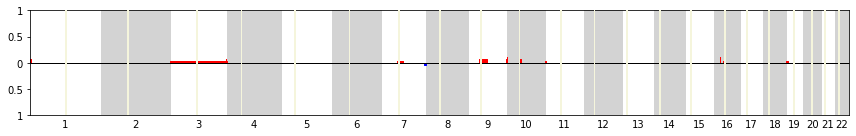

32 samples total
32 lesions


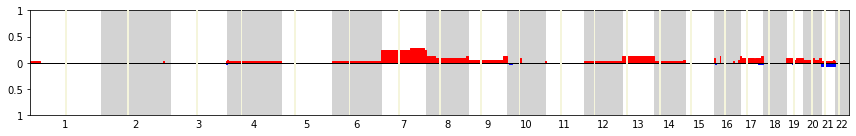

55 samples total
55 lesions


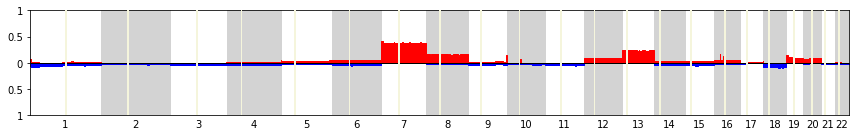

In [7]:
# ED Fig. 3a- HTAN CNs
to_plot = HTAN_CNs[HTAN_CNs["stage"]=="Mucosa"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3a_HTAN_mucosa_CNA.pdf")

to_plot = HTAN_CNs[HTAN_CNs["stage"]=="Benign"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3a_HTAN_benign_CNA.pdf")

to_plot = HTAN_CNs[HTAN_CNs["stage"]=="Dysplasia"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3a_HTAN_dysplasia_CNA.pdf")

7 samples total
5 lesions


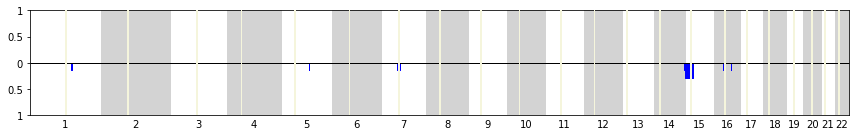

13 samples total
10 lesions


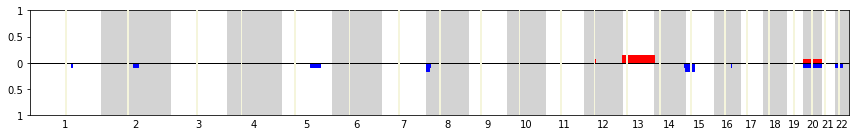

22 samples total
9 lesions


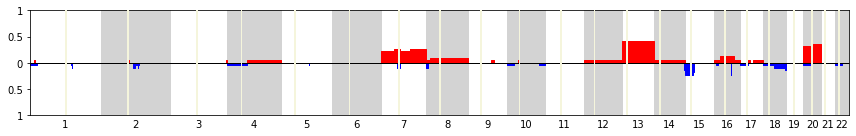

10 samples total
5 lesions


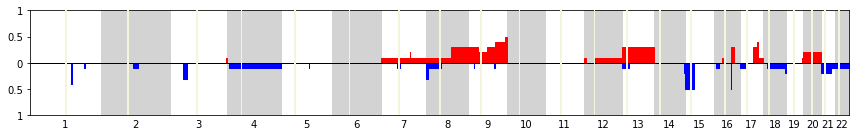

In [8]:
# ED Fig. 3b- PUTH CNs
assert "PUTH" in dataset_names, "PUTH dataset not processed"

PUTH_CNs = merged_filtered_datasets["PUTH"]

to_plot = PUTH_CNs[PUTH_CNs["stage"]=="Mucosa"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3b_PUTH_mucosa_CNA.pdf")

to_plot = PUTH_CNs[PUTH_CNs["stage"]=="Benign"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3b_PUTH_benign_CNA.pdf")

to_plot = PUTH_CNs[PUTH_CNs["stage"]=="Dysplasia"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3b_PUTH_dysplasia_CNA.pdf")

to_plot = PUTH_CNs[PUTH_CNs["stage"]=="AdCa"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3b_PUTH_AdCa_CNA.pdf")

25 samples total
8 lesions


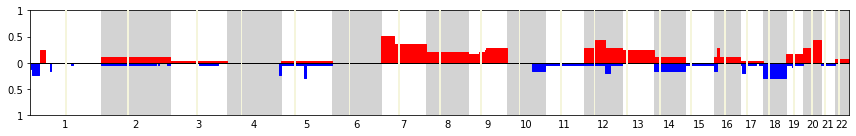

21 samples total
2 lesions


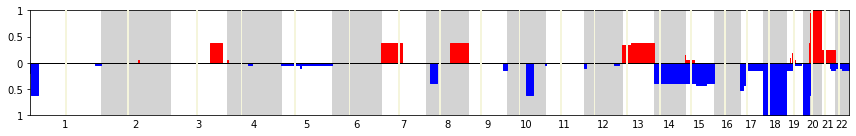

In [9]:
# ED Fig. 3c- SCORT CNs
assert "SCORT" in dataset_names, "SCORT dataset not processed"

SCORT_CNs = merged_filtered_datasets["SCORT"]

to_plot = SCORT_CNs[SCORT_CNs["stage"]=="Adenoma"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3c_SCORT_adenoma_CNA.pdf")

to_plot = SCORT_CNs[SCORT_CNs["stage"]=="Carcinoma"]
fig, ax, plotted_df = plot_population_CNs(to_plot)
if save_plots:
    fig.savefig(plots_dir+"ED3c_SCORT_carcinoma_CNA.pdf")

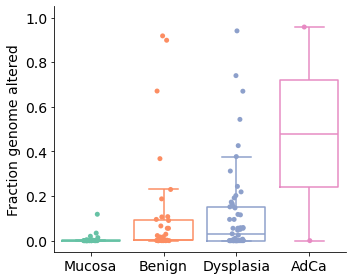

Mann Whitney U test: Mucosa vs. Benign FGA
MannwhitneyuResult(statistic=250.5, pvalue=0.00034184796004787973)

Mann Whitney U test: Mucosa vs. Dysplasia FGA
MannwhitneyuResult(statistic=445.0, pvalue=0.000257147205350316)

Mann Whitney U test: Dysplasia vs. Benign FGA
MannwhitneyuResult(statistic=1022.0, pvalue=0.8449798639927721)


In [10]:
# ED Fig. 3d- HTAN FGA
fig, ax = plt.subplots(1,1, figsize=(5,4))
plot_groups = ["Mucosa", "Benign", "Dysplasia", "AdCa"]
sns.boxplot(x=HTAN_FGA["stage"], y=HTAN_FGA["FGA"], hue=HTAN_FGA["stage"], dodge=False, order=plot_groups, palette=dict(zip(plot_groups, set2_colors[:len(plot_groups)])), showfliers=False, fill=False, legend=False)
sns.stripplot(x=HTAN_FGA["stage"], y=HTAN_FGA["FGA"], hue=HTAN_FGA["stage"], dodge=False, order=plot_groups, palette=dict(zip(plot_groups, set2_colors[:len(plot_groups)])), legend=False)
sns.despine()
plt.xlabel("")
plt.ylabel("Fraction genome altered", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.05,1.05)
plt.tight_layout()
if save_plots:
    fig.savefig(plots_dir+"ED3d_HTAN_FGA.pdf")
plt.show()

print("Mann Whitney U test: Mucosa vs. Benign FGA")
print(mannwhitneyu(HTAN_FGA[HTAN_FGA["stage"]=="Mucosa"]["FGA"], HTAN_FGA[HTAN_FGA["stage"]=="Benign"]["FGA"]))
print("\nMann Whitney U test: Mucosa vs. Dysplasia FGA")
print(mannwhitneyu(HTAN_FGA[HTAN_FGA["stage"]=="Mucosa"]["FGA"], HTAN_FGA[HTAN_FGA["stage"]=="Dysplasia"]["FGA"]))
print("\nMann Whitney U test: Dysplasia vs. Benign FGA")
print(mannwhitneyu(HTAN_FGA[HTAN_FGA["stage"]=="Dysplasia"]["FGA"], HTAN_FGA[HTAN_FGA["stage"]=="Benign"]["FGA"]))

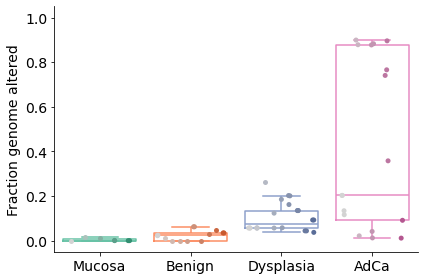

In [11]:
# ED Fig. 3e- PUTH FGA
assert "PUTH" in dataset_names, "PUTH dataset not processed"

PUTH_FGA = fga["PUTH"]
plot_groups = ["Mucosa", "Benign", "Dysplasia", "AdCa"]

lesion_to_plot = {}
for stage in plot_groups:
    all_lesions = sorted(list(set(PUTH_FGA[PUTH_FGA["stage"]==stage]["lesion"])))
    lesion_to_plot.update(dict(zip(all_lesions, range(len(all_lesions)))))

PUTH_FGA["lesion_plot"] = [lesion_to_plot[x] for x in PUTH_FGA["lesion"]]

fig, ax = plt.subplots(1,1, figsize=(6,4))

sns.boxplot(x=PUTH_FGA["stage"], y=PUTH_FGA["FGA"], hue=PUTH_FGA["stage"], dodge=False, order=plot_groups, palette=dict(zip(plot_groups, set2_colors[:len(plot_groups)])), showfliers=False, fill=False, legend=False)
sns.stripplot(x=PUTH_FGA[PUTH_FGA["stage"]=="Mucosa"]["stage"], y=PUTH_FGA[PUTH_FGA["stage"]=="Mucosa"]["FGA"], hue=PUTH_FGA[PUTH_FGA["stage"]=="Mucosa"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="mucosa_cmap", colors=["lightgrey", darken_rgb(set2_colors[0], 0.2)]), legend=False)
sns.stripplot(x=PUTH_FGA[PUTH_FGA["stage"]=="Benign"]["stage"], y=PUTH_FGA[PUTH_FGA["stage"]=="Benign"]["FGA"], hue=PUTH_FGA[PUTH_FGA["stage"]=="Benign"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="benign_cmap", colors=["lightgrey", darken_rgb(set2_colors[1], 0.2)]), legend=False)
sns.stripplot(x=PUTH_FGA[PUTH_FGA["stage"]=="Dysplasia"]["stage"], y=PUTH_FGA[PUTH_FGA["stage"]=="Dysplasia"]["FGA"], hue=PUTH_FGA[PUTH_FGA["stage"]=="Dysplasia"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="dys_cmap", colors=["lightgrey", darken_rgb(set2_colors[2], 0.2)]), legend=False)
sns.stripplot(x=PUTH_FGA[PUTH_FGA["stage"]=="AdCa"]["stage"], y=PUTH_FGA[PUTH_FGA["stage"]=="AdCa"]["FGA"], hue=PUTH_FGA[PUTH_FGA["stage"]=="AdCa"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="adca_cmap", colors=["lightgrey", darken_rgb(set2_colors[3], 0.2)]), legend=False)

sns.despine()
plt.xlabel("")
plt.ylabel("Fraction genome altered", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.05,1.05)
plt.tight_layout()
if save_plots:
    fig.savefig(plots_dir+"ED3e_PUTH_FGA.pdf")
plt.show()

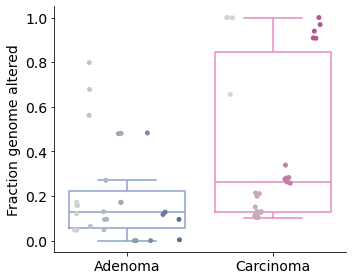

In [12]:
# ED Fig. 3f- SCORT FGA
assert "SCORT" in dataset_names, "SCORT dataset not processed"

SCORT_FGA = fga["SCORT"]
plot_groups = ["Adenoma", "Carcinoma"]

lesion_to_plot = {}
for stage in plot_groups:
    all_lesions = sorted(list(set(SCORT_FGA[SCORT_FGA["stage"]==stage]["lesion"])))
    lesion_to_plot.update(dict(zip(all_lesions, range(len(all_lesions)))))

SCORT_FGA["lesion_plot"] = [lesion_to_plot[x] for x in SCORT_FGA["lesion"]]

fig, ax = plt.subplots(1,1, figsize=(5,4))

sns.boxplot(x=SCORT_FGA["stage"], y=SCORT_FGA["FGA"], hue=SCORT_FGA["stage"], dodge=False, order=plot_groups, palette=dict(zip(plot_groups, set2_colors[2:4])), showfliers=False, fill=False, legend=False)
sns.stripplot(x=SCORT_FGA[SCORT_FGA["stage"]=="Adenoma"]["stage"], y=SCORT_FGA[SCORT_FGA["stage"]=="Adenoma"]["FGA"], hue=SCORT_FGA[SCORT_FGA["stage"]=="Adenoma"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="dys_cmap", colors=["lightgrey", darken_rgb(set2_colors[2], 0.2)]), legend=False)
sns.stripplot(x=SCORT_FGA[SCORT_FGA["stage"]=="Carcinoma"]["stage"], y=SCORT_FGA[SCORT_FGA["stage"]=="Carcinoma"]["FGA"], hue=SCORT_FGA[SCORT_FGA["stage"]=="Carcinoma"]["lesion_plot"], dodge=True, order=plot_groups, palette=LinearSegmentedColormap.from_list(name="adca_cmap", colors=["lightgrey", darken_rgb(set2_colors[3], 0.2)]), legend=False)

sns.despine()
plt.xlabel("")
plt.ylabel("Fraction genome altered", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.05,1.05)
plt.tight_layout()
if save_plots:
    fig.savefig(plots_dir+"ED3f_SCORT_FGA.pdf")
plt.show()